titanic mortality predictions

In [147]:
import numpy as np
import pandas as pd

train_data = pd.read_csv("train.csv")
test_data = pd.read_csv("test.csv")


In [148]:
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [149]:
train_data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


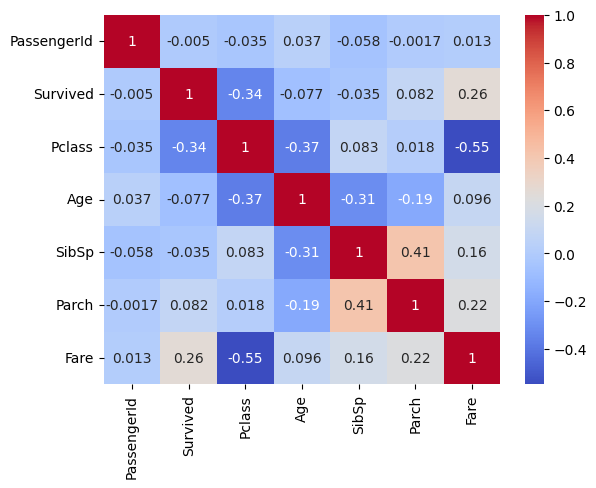

In [150]:
# investigating correlation in just the numeric columns
import seaborn as sns
import matplotlib.pyplot as plt

# get the numeric columns
numeric_df = train_data.select_dtypes(include=['float64', 'int64'])

sns.heatmap(numeric_df.corr(), cmap='coolwarm', annot=True)
plt.show()

In [151]:
from sklearn.model_selection import StratifiedShuffleSplit

# split trainign data before using test set
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2)

for train_index, test_index in split.split(train_data, train_data[["Survived", "Pclass", "Sex"]]):
    strat_train_set = train_data.loc[train_index]
    strat_test_set = train_data.loc[test_index]

In [152]:
strat_train_set.info()

<class 'pandas.core.frame.DataFrame'>
Index: 712 entries, 386 to 789
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  712 non-null    int64  
 1   Survived     712 non-null    int64  
 2   Pclass       712 non-null    int64  
 3   Name         712 non-null    object 
 4   Sex          712 non-null    object 
 5   Age          579 non-null    float64
 6   SibSp        712 non-null    int64  
 7   Parch        712 non-null    int64  
 8   Ticket       712 non-null    object 
 9   Fare         712 non-null    float64
 10  Cabin        158 non-null    object 
 11  Embarked     710 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 72.3+ KB


In [153]:
# checking missing values
def display_missing_columns(df):
    print("Columns with missing values:")
    for col in df.columns:
        missing_count = df[col].isnull().sum()
        if missing_count > 0:
            print(f'{col} column missing values: {missing_count}')
    print('\n')

display_missing_columns(strat_train_set)

Columns with missing values:
Age column missing values: 133
Cabin column missing values: 554
Embarked column missing values: 2




In [154]:
# Buidling the pipeline

# deal with missing values
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer

# replace null values with missing values in Age
# based on the median age of groups defined by Sex and Pclass
class AgeImputer(BaseEstimator, TransformerMixin):
    def __init__(self):
        # Storing median ages
        self.age_medians = {}

    def fit(self, X, y=None):
        # Calculate median ages for each combination of Sex and Pclass
        self.age_medians = X.groupby(['Sex', 'Pclass'])['Age'].median().to_dict()
        return self
    
    def transform(self, X):
        # for each Sex and Pclass group
        for (sex, pclass), median_age in self.age_medians.items():
            # Apply median age to the specific group where Age is NaN
            condition = (X['Sex'] == sex) & (X['Pclass'] == pclass)
            X.loc[condition & X['Age'].isna(), 'Age'] = median_age
        return X
    
        

In [155]:
# one hot encode the gender
from sklearn.preprocessing import OneHotEncoder

class FeatureEncoder(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        encoder = OneHotEncoder()
        
        # for embarked
        matrix = encoder.fit_transform(X[["Embarked"]]).toarray()
        column_names = ["C", "S", "Q", "N"] # column names for ticket class
        
        for i in range(len(matrix.T)):
            X[column_names[i]] = matrix.T[i]
        
        # then for gender
        matrix = encoder.fit_transform(X[["Sex"]]).toarray()
        column_names = ["Male", "Female"]
        
        for i in range(len(matrix.T)):
            X[column_names[i]] = matrix.T[i]
            
        return X

In [156]:
# drop non important features

class FeatureDropper(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X.drop(["Name", "Embarked", "Ticket", "Cabin", "Sex", "N"], axis=1, errors='ignore')

In [157]:
# assemble the pipeline
from sklearn.pipeline import Pipeline

pipeline = Pipeline([("AgeImputer", AgeImputer()), 
                     ("FeatureEncoder", FeatureEncoder()), 
                     ("FeatureDropper", FeatureDropper())])

In [158]:
# run the pipeline on the stratified training set

strat_train_set = pipeline.fit_transform(strat_train_set)


In [159]:
strat_train_set.head()


,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,C,S,Q,Male,Female
386,387,0,3,1.0,5,2,46.9000,0.0,0.0,1.0,0.0,1.0
686,687,0,3,14.0,4,1,39.6875,0.0,0.0,1.0,0.0,1.0
287,288,0,3,22.0,0,0,7.8958,0.0,0.0,1.0,0.0,1.0
555,556,0,1,62.0,0,0,26.5500,0.0,0.0,1.0,0.0,1.0
69,70,0,3,26.0,2,0,8.6625,0.0,0.0,1.0,0.0,1.0


In [160]:
# checking again for missing values
display_missing_columns(strat_train_set)

Columns with missing values:




In [161]:
# scale date before training

from sklearn.preprocessing import StandardScaler

X = strat_train_set.drop("Survived", axis=1)
Y = strat_train_set["Survived"]

scaler = StandardScaler()
x_data = scaler.fit_transform(X)
y_data = Y.to_numpy()



In [162]:
# train the model
# using random forest tree here

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

classifier = RandomForestClassifier()
param_grid = [
    {'n_estimators': [10, 100, 200, 500],
     'max_depth': [None, 5, 10],
     'min_samples_split': [2, 3, 4]}
]

grid_search = GridSearchCV(classifier, param_grid, cv=3, scoring='accuracy', return_train_score=True)
grid_search.fit(x_data, y_data)


GridSearchCV(cv=3, estimator=RandomForestClassifier(),
             param_grid=[{'max_depth': [None, 5, 10],
                          'min_samples_split': [2, 3, 4],
                          'n_estimators': [10, 100, 200, 500]}],
             return_train_score=True, scoring='accuracy')

In [163]:
# get best paramters
final_classifier = grid_search.best_estimator_

In [164]:
final_classifier

RandomForestClassifier(min_samples_split=4)

In [165]:
# run on test set and score
strat_test_set = pipeline.fit_transform(strat_test_set)


In [166]:
strat_train_set.head()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,C,S,Q,Male,Female
386,387,0,3,1.0,5,2,46.9000,0.0,0.0,1.0,0.0,1.0
686,687,0,3,14.0,4,1,39.6875,0.0,0.0,1.0,0.0,1.0
287,288,0,3,22.0,0,0,7.8958,0.0,0.0,1.0,0.0,1.0
555,556,0,1,62.0,0,0,26.5500,0.0,0.0,1.0,0.0,1.0
69,70,0,3,26.0,2,0,8.6625,0.0,0.0,1.0,0.0,1.0


In [167]:
X = strat_test_set.drop("Survived", axis=1)
Y = strat_test_set["Survived"]

x_test_data = scaler.transform(X)
y_test_data = Y.to_numpy()


In [168]:
final_classifier.score(x_test_data, y_test_data)

0.8324022346368715

In [169]:
# now to run it on the full data
full_train_data = pipeline.fit_transform(train_data)

In [170]:
X_final = full_train_data.drop("Survived", axis=1)
Y_final = full_train_data["Survived"]

x_final_data = scaler.fit_transform(X_final)
y_final_data = Y_final.to_numpy()

final_classifier.fit(x_final_data, y_final_data)

RandomForestClassifier(min_samples_split=4)

In [171]:
# output predictions to csv
final_test_data = pipeline.fit_transform(test_data)

In [172]:
x_final_test = final_test_data
x_final_test = x_final_test.fillna(method='ffill')

x_final_test_data = scaler.transform(x_final_test)

/var/folders/s3/h_lpz7853xx43bm0p8lh9gfw0000gn/T/ipykernel_24510/3361664540.py:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  x_final_test = x_final_test.fillna(method='ffill')


In [173]:
predictions = final_classifier.predict(x_final_test_data)

In [174]:
predictions_df = pd.DataFrame(test_data['PassengerId'])
predictions_df['Survived'] = predictions
predictions_df.to_csv("predictions.csv", index=False)